# Training Materials: Alos-2 Data Preprocessing with Lee Filter and Calibration

This notebook provides a comprehensive guide to preprocessing Alos-2 data, focusing on speckle noise reduction using the Lee filter and calibration.  We will cover loading, clipping, calibration, filtering, visualization, and saving of preprocessed data.

## I. Preprocessing for Alos-2 Data

* **Why Preprocess?**

 Raw Alos-2 data often contains speckle noise, which appears as a granular texture and hinders analysis. Preprocessing, including calibration and filtering, is essential to reduce speckle noise and ensure accurate data interpretation. Calibration converts the digital numbers to physical units, enabling quantitative analysis.
* **Overview of the Preprocessing Workflow:**

 The workflow involves loading the data, clipping it to an area of interest (AOI), calibrating the pixel values, applying the Lee filter for speckle reduction, and finally, saving the processed data.

## II. Setting up the Environment

In [5]:
!pip install rasterio geopandas numpy matplotlib scipy scikit-image


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


* **A. Installing Necessary Libraries:**
    * `rasterio`: For handling raster data (reading and writing GeoTIFF files).
    * `geopandas`: For working with vector data, such as shapefiles defining the AOI.
    * `numpy`: For numerical operations on arrays.
    * `matplotlib`: For visualizing images.
    * `scipy`: For scientific computing, including image filtering.
    * `skimage`: For image processing, including resizing.
* **B. Importing Libraries in Python:**

In [6]:
import os
import numpy as np
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from skimage.transform import resize
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter

## III. Loading Alos-2 Data

In [13]:
import os
import rasterio

# Define the correct directory
directory = r'/home/jovyan/shared/Sirinya/gen_ai/Shimpomachi_ngo'

# Change to the specified directory
os.chdir(directory)

# List all GeoTIFF files in the folder
alos_files = [f for f in os.listdir() if f.endswith('.tif')]

if not alos_files:
    raise FileNotFoundError("No GeoTIFF files found in the specified directory.")
    
# Display list of files found
print("ALOS-2 files to visualize:")
for file in alos_files:
    print(file)
    
alos_image = []
for file in alos_files:
    with rasterio.open(os.path.join(directory, file)) as src:
        alos_image.append(src.read(1))  # Read the first band


ALOS-2 files to visualize:
HH-191127.tif
HH-200304.tif
HH-200610.tif
HH-210303.tif
HH-210609.tif
HH-211124.tif
HH-220302.tif


## IV. Applying the Lee Filter for Speckle Noise Reduction

In [14]:
import numpy as np
from scipy.ndimage import uniform_filter

# Define the Lee filter function
def lee_filter(image, size):
    """
    Applies the Lee filter to an input image to reduce speckle noise.
    
    Parameters:
        image (numpy.ndarray): The input image to be filtered.
        size (int or tuple): The size of the local neighborhood (e.g., window size).
        
    Returns:
        numpy.ndarray: The filtered image.
    """
    # Ensure the input image is a floating-point array for precision
    image = image.astype(np.float32)
    
    # Calculate local mean and squared mean using uniform filter
    local_mean = uniform_filter(image, size=size)
    local_mean_sqr = uniform_filter(image**2, size=size)
    
    # Calculate local variance
    local_variance = local_mean_sqr - local_mean**2
    
    # Estimate noise variance (overall variance of the image)
    overall_variance = np.mean(local_variance)
    
    # Compute the filter weight
    weight = local_variance / (local_variance + overall_variance)
    weight = np.clip(weight, 0, 1)  # Ensure weight is in a valid range
    
    # Apply the Lee filter formula
    filtered_image = local_mean + weight * (image - local_mean)
    
    return filtered_image

# Apply Lee filter
filtered_images = list()
for img in alos_image:
    filtered_images.append(lee_filter(img, size=3))  # Adjust size as needed


## V. Calibrating Alos-2 Data
* **A. Understanding Calibration:** Calibration converts digital numbers to physical units (backscatter). The formula `calibrated_image = (10 * np.log10(image**2)) - 83` is used, where 83 is a scaling factor.
* **B. Implementing Calibration in Python:**

In [15]:
import numpy as np
import rasterio

# Define a function to calibrate the image
def calibrate_image(image):
    # Clip negative values to avoid taking log of non-positive values
    clipped_image = np.clip(image, a_min=1e-10, a_max=None)  # Prevent log(0)
    # Apply calibration formula
    calibrated_image = (10 * np.log10(clipped_image**2)) - 83
    return calibrated_image

# Apply calibration to filtered images and store in a dictionary
preprocessed_images = []
for img in filtered_images:
    # Calibrate the filtered image
    preprocessed_images.append(calibrate_image(img))


## VI. Visualizing Results

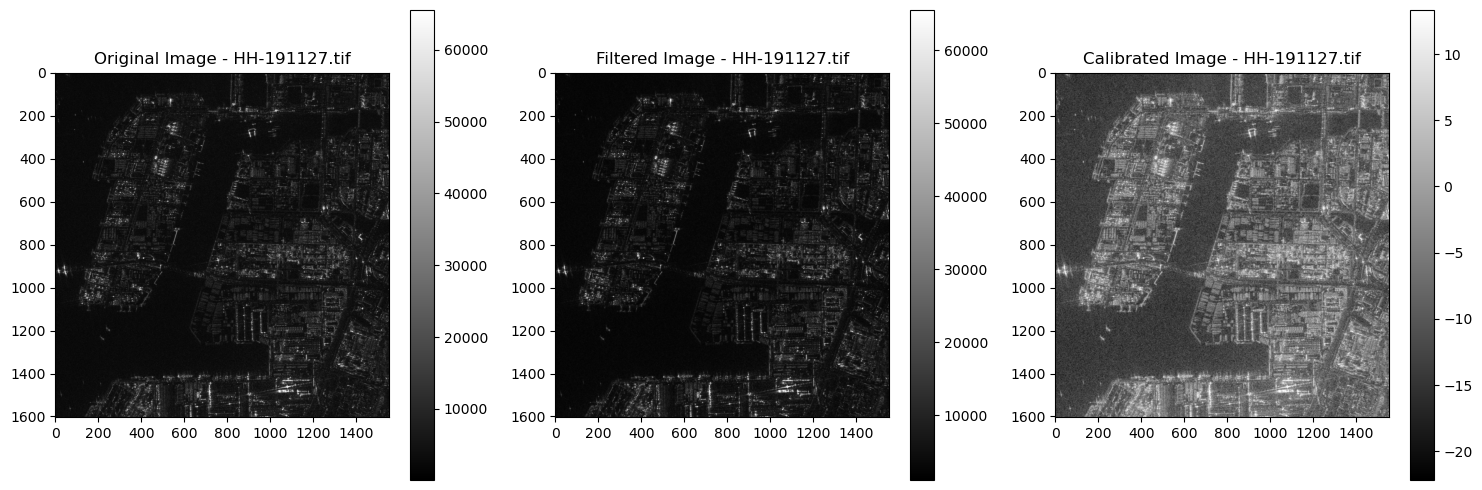

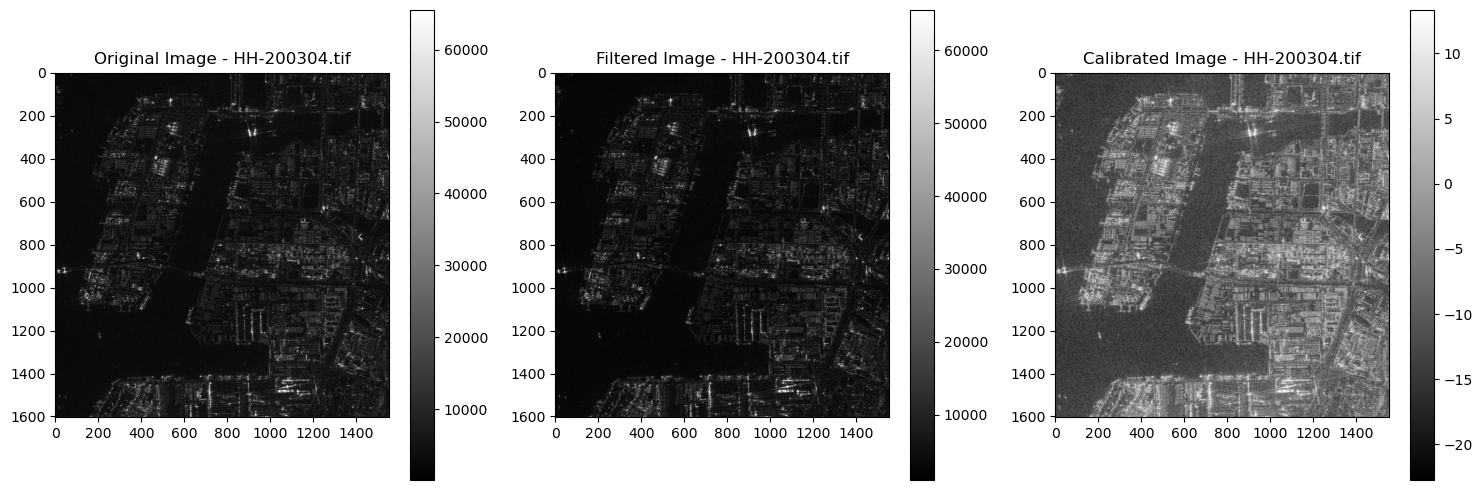

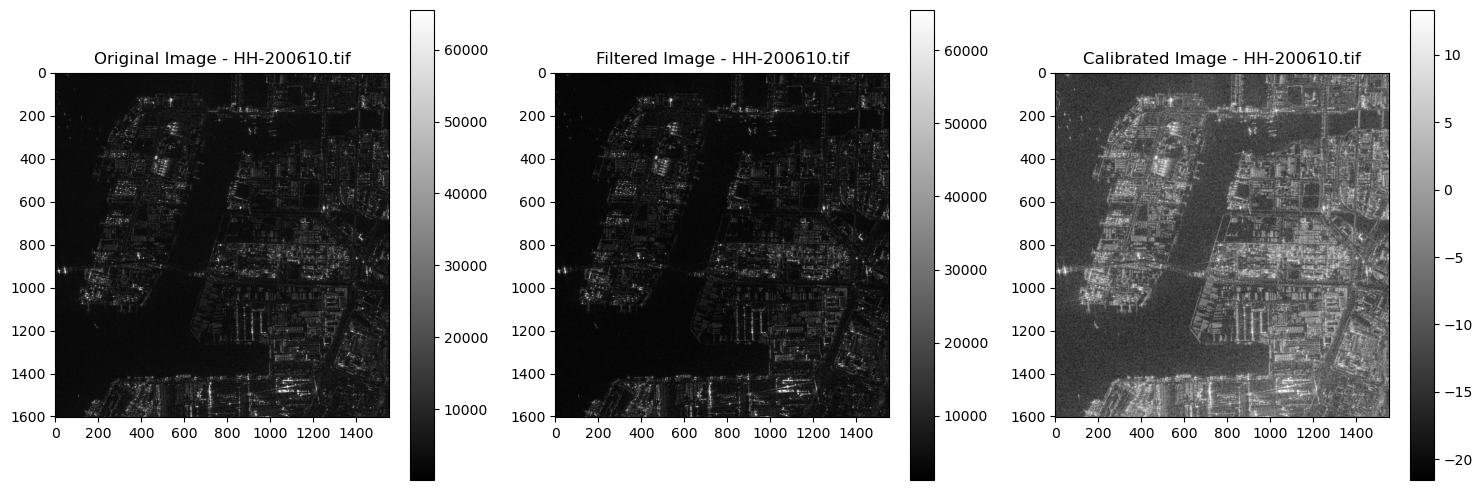

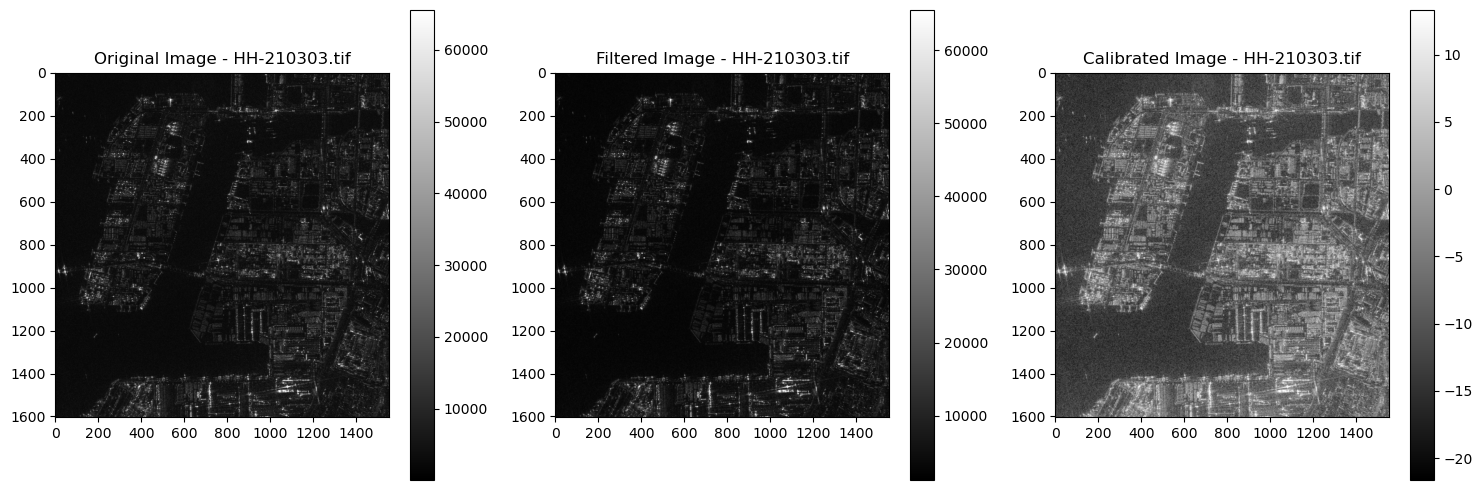

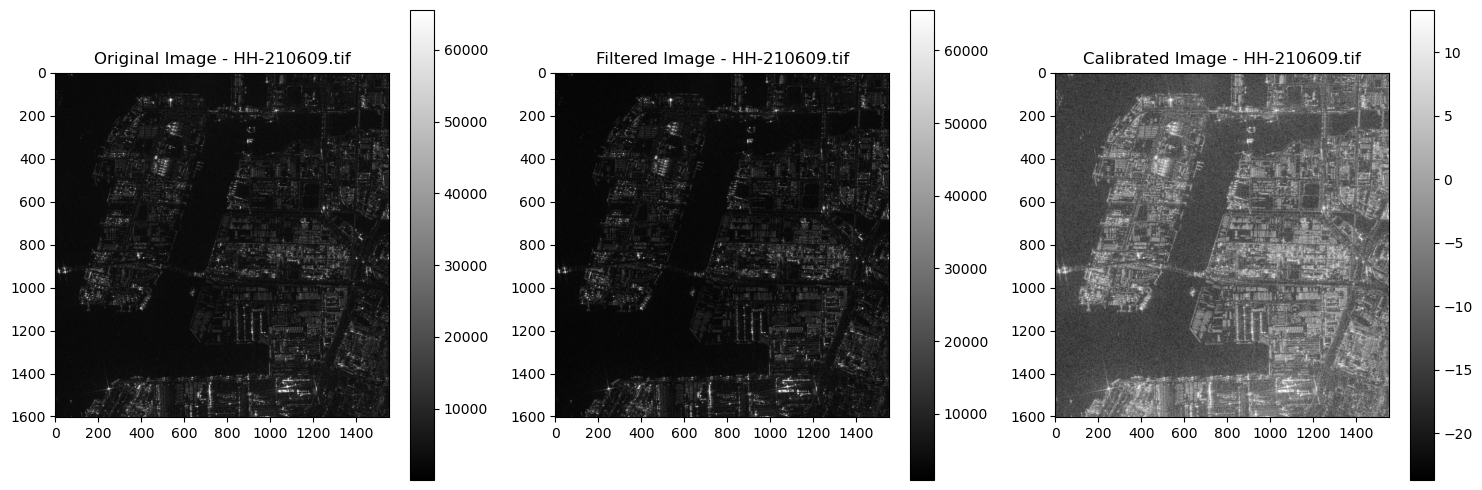

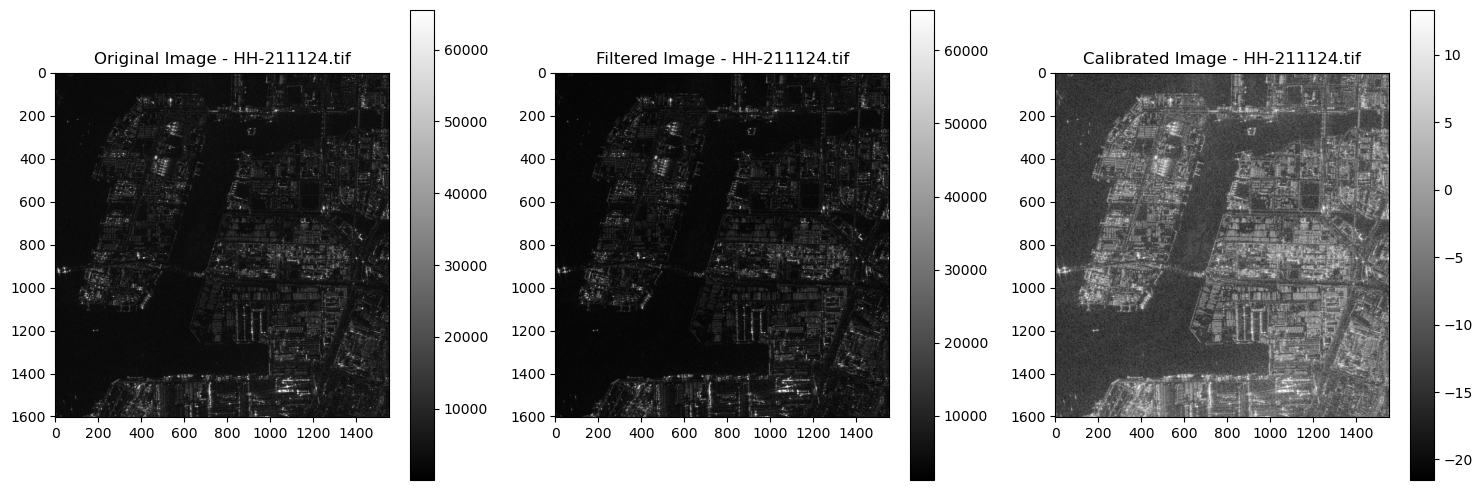

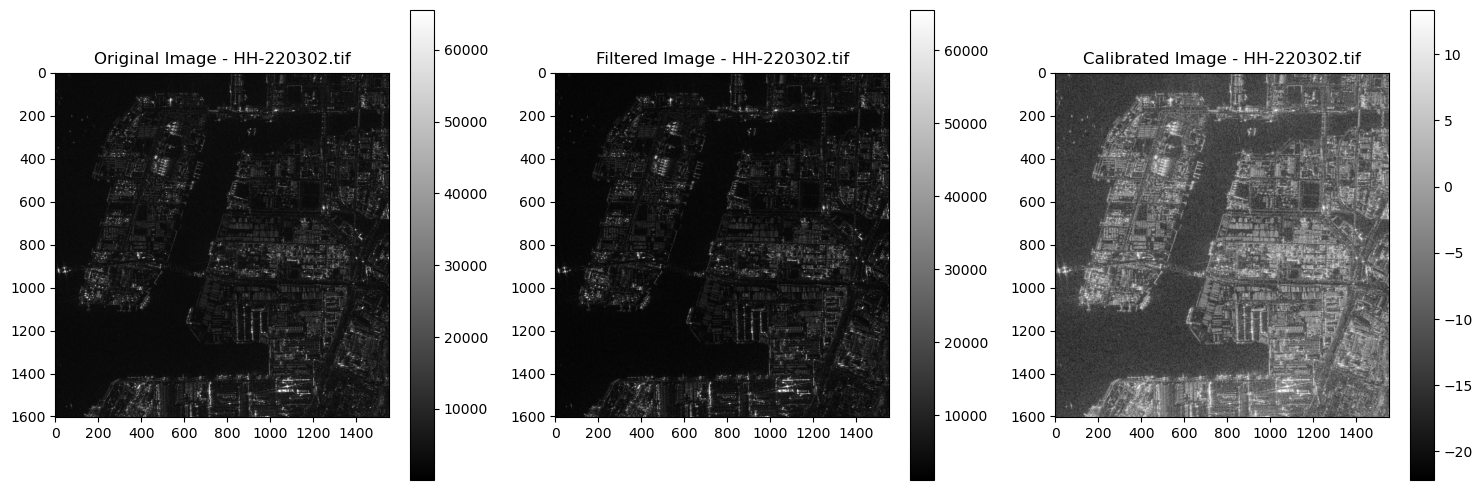

In [16]:
import matplotlib.pyplot as plt
import os
import rasterio

# Visualize Original, Calibrated, and Filtered Images side-by-side
for i in range(0, len(alos_files)):
    # Plot
    plt.figure(figsize=(15, 5))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(alos_image[i], cmap='gray')
    plt.title(f"Original Image - {os.path.basename(alos_files[i])}")
    plt.colorbar()

    # Filtered Image
    plt.subplot(1, 3, 2)
    plt.imshow(filtered_images[i], cmap='gray')
    plt.title(f"Filtered Image - {os.path.basename(alos_files[i])}")
    plt.colorbar()

    # Calibrated Image
    plt.subplot(1, 3, 3)
    plt.imshow(preprocessed_images[i], cmap='gray')
    plt.title(f"Calibrated Image - {os.path.basename(alos_files[i])}")
    plt.colorbar()


    plt.tight_layout()
    plt.show()
